In [1]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import neurogym as ngym
from torch.nn import init
from torch.nn import functional as F
import math
import logging

c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


# Coursework
This is the code for question 2.c
### 2.c

First of all, let's train a Leaky RNN to perform the task PerceptualDecisionMaking-v0.

In [2]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

Let's determine the dimensions of its inputs and outputs.

In [3]:
batch_size = 16
seq_len = 20  # sequence length
input_size = 5  # input dimension

# Make some random inputs
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Make network of 100 hidden units and 10 output units
rnn = RNNNet(input_size=input_size, hidden_size=100, output_size=10)

# Run the sequence through the network
out, rnn_output = rnn(input_rnn)

print('Input of shape =', input_rnn.shape)
print('Output of shape =', out.shape)

Input of shape = torch.Size([20, 16, 5])
Output of shape = torch.Size([20, 16, 10])


In [4]:
# Canned environment from neurogym

task_name = 'ContextDecisionMaking-v0'

# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}


c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 7])
Target has shape (SeqLen, Batch) = (100, 16)


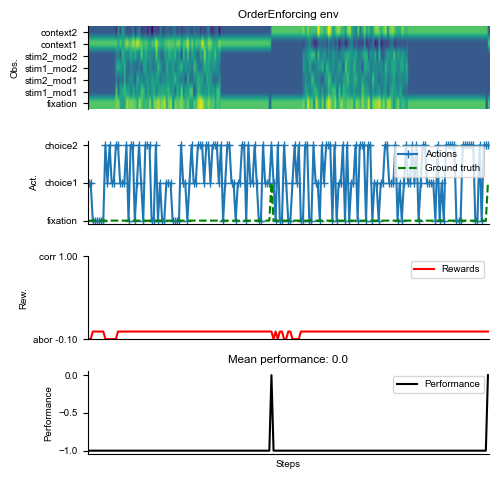

In [5]:
# Make supervised dataset
seq_len = 100
batch_size = 16
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Let's now train the network to perform the task.

In [6]:
# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

def train_model(net, dataset):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(2000):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, activity = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

net = train_model(net, dataset)

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=7, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.1672, Time 4.6s
Step 200, Loss 0.0694, Time 8.6s
Step 300, Loss 0.0410, Time 13.2s
Step 400, Loss 0.0347, Time 18.0s
Step 500, Loss 0.0325, Time 22.8s
Step 600, Loss 0.0309, Time 27.5s
Step 700, Loss 0.0303, Time 32.3s
Step 800, Loss 0.0307, Time 37.2s
Step 900, Loss 0.0305, Time 42.1s
Step 1000, Loss 0.0296, Time 46.8s
Step 1100, Loss 0.0290, Time 51.6s
Step 1200, Loss 0.0299, Time 56.5s
Step 1300, Loss 0.0291, Time 61.4s
Step 1400, Loss 0.0290, Time 66.3s
Step 1500, Loss 0.0292, Time 71.1s
Step 1600, Loss 0.0289, Time 76.2s
Step 1700, Loss 0.0293, Time 80.4s
Step 1800, Loss 0.0291, Time 85.8s
Step 1900, Loss 0.0293, Time 90.8s
Step 2000, Loss 0.0290, Time 95.9s


Now we will proceed to test the network.

Trial  0 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 5, 'coh_1': 15, 'correct': False}
Trial  1 {'ground_truth': 1, 'other_choice': 2, 'context': 1, 'coh_0': 15, 'coh_1': 15, 'correct': False}
Trial  2 {'ground_truth': 1, 'other_choice': 2, 'context': 1, 'coh_0': 50, 'coh_1': 50, 'correct': False}
Trial  3 {'ground_truth': 2, 'other_choice': 1, 'context': 0, 'coh_0': 15, 'coh_1': 50, 'correct': True}
Trial  4 {'ground_truth': 2, 'other_choice': 2, 'context': 0, 'coh_0': 15, 'coh_1': 50, 'correct': True}
Average performance 0.51


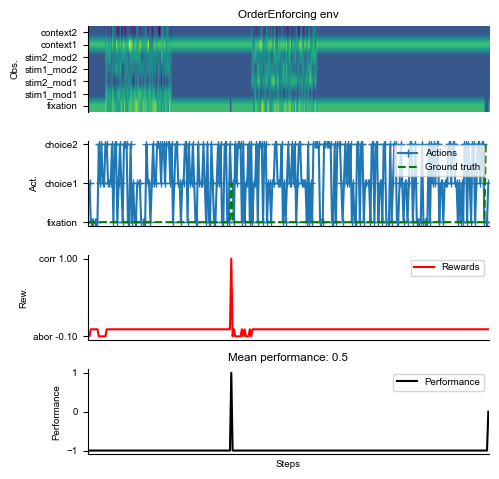

In [7]:
# Reset environment
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information
stim_activity = [[], []]  # response for ground-truth 0 and 1

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]

    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

    # Log stimulus period activity
    #rnn_activity = rnn_activity[:, 0]
    rnn_activity = rnn_activity[:,:]
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    # edition here
    #rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    #stim_activity[env.trial['ground_truth']].append(rnn_activity)

# Print information for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Text(0, 0.5, 'Activity')

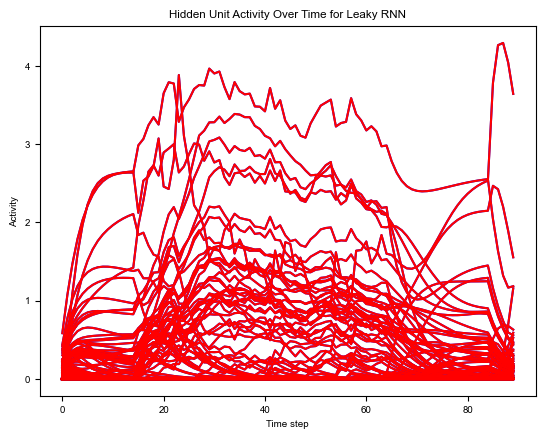

In [8]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.hidden_size
trial = 2

plt.figure()
#_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
#_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
_ = plt.plot(activity_dict[trial][:], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:], color='red', label='Inhibitory')

plt.title('Hidden Unit Activity Over Time for Leaky RNN')
plt.xlabel('Time step')
plt.ylabel('Activity')

Text(0.5, 1.0, 'Network connectivity')

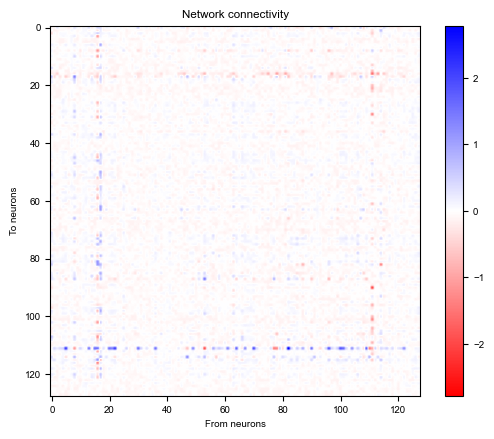

In [9]:

# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
#plt.figure()
#plt.hist(selectivity)
#plt.xlabel('Selectivity')
#plt.ylabel('Number of neurons')

W = net.rnn.h2h.weight.detach().numpy()
# Sort by selectivity
W = W[:, :][:, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

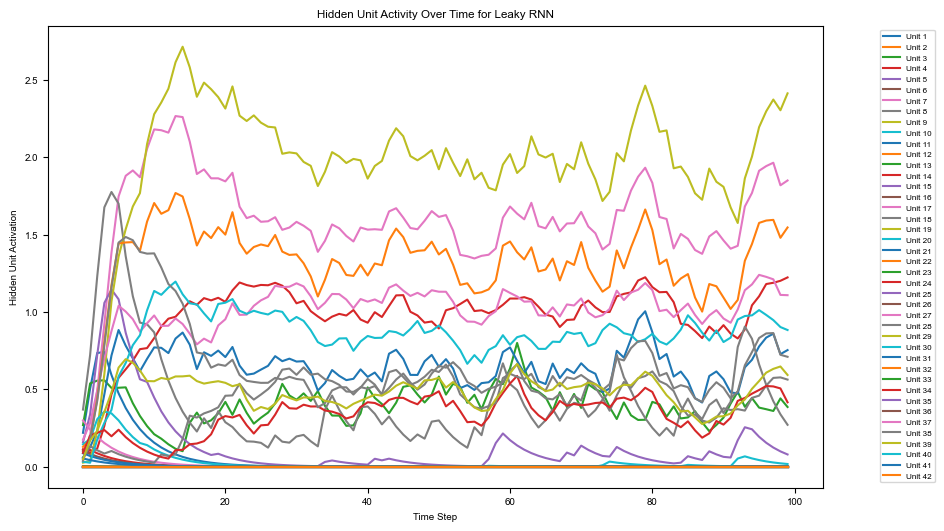

In [10]:
# Ejecutar un forward pass en la red para generar actividad oculta
seq_len = 100  # Longitud de la secuencia
batch_size = 1  # Procesar un lote a la vez para análisis individual
input_size = net.rnn.input_size

# Crear una entrada aleatoria para simular datos
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Pasar los datos a través de la red
_, rnn_output = net(input_rnn)

# `rnn_output` tiene la forma (SeqLen, Batch, HiddenSize)
# Seleccionar el primer lote
hidden_activity = rnn_output[:, 0, :].detach().numpy()

# Graficar la actividad de las unidades ocultas
plt.figure(figsize=(10, 6))
for i in range(hidden_activity.shape[1]//3):
    plt.plot(hidden_activity[:, i], label=f'Unit {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Activation')
plt.title('Hidden Unit Activity Over Time for Leaky RNN')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.show()


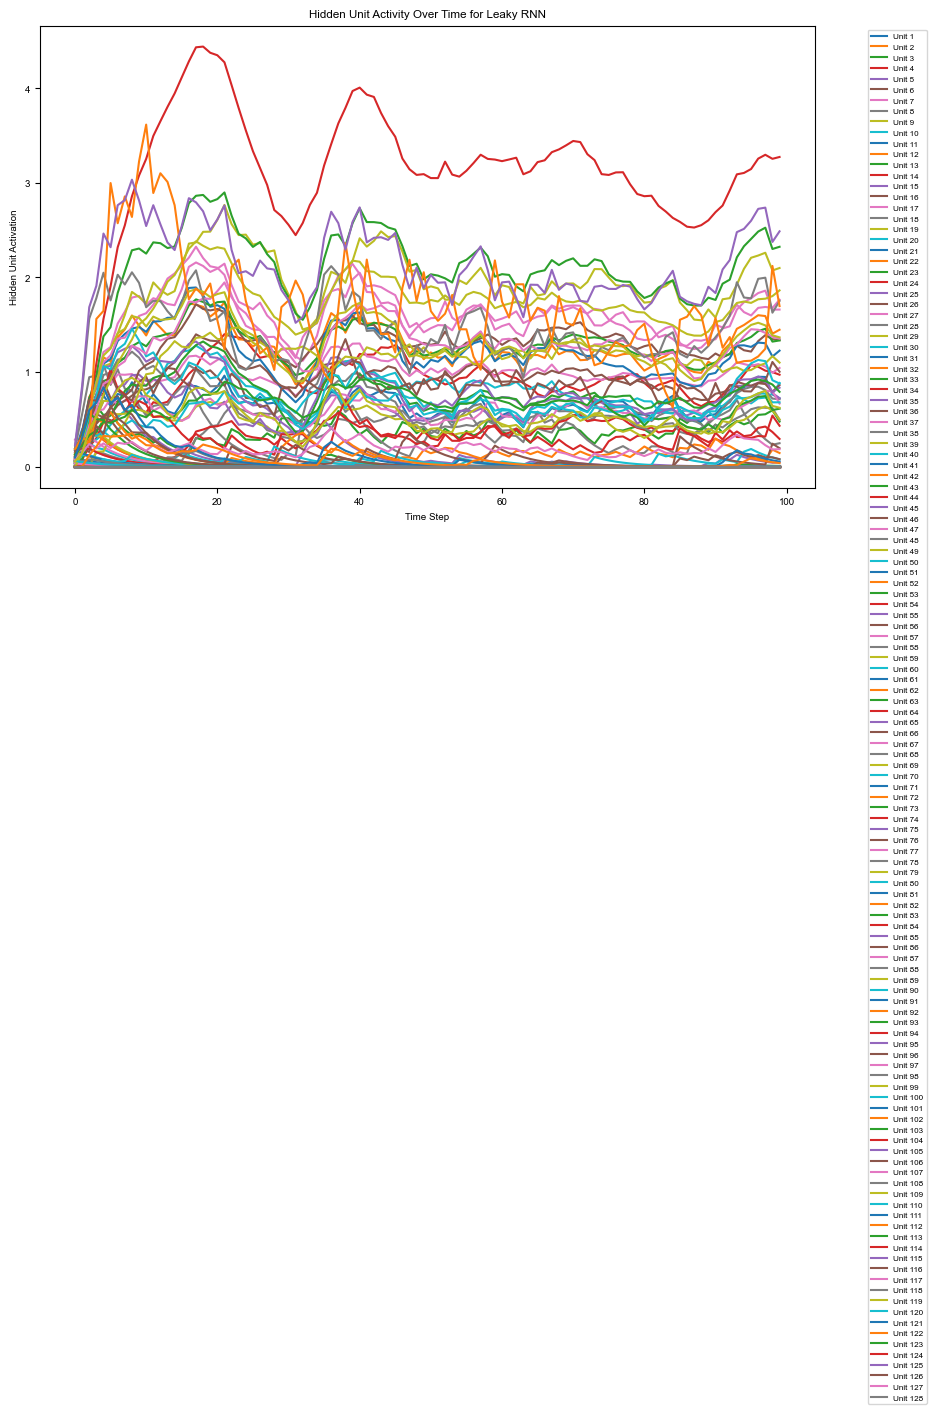

In [11]:
# Ejecutar un forward pass en la red para generar actividad oculta
seq_len = 100  # Longitud de la secuencia
batch_size = 1  # Procesar un lote a la vez para análisis individual
input_size = net.rnn.input_size

# Crear una entrada aleatoria para simular datos
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Pasar los datos a través de la red
_, rnn_output = net(input_rnn)

# `rnn_output` tiene la forma (SeqLen, Batch, HiddenSize)
# Seleccionar el primer lote
hidden_activity = rnn_output[:, 0, :].detach().numpy()

# Graficar la actividad de las unidades ocultas
plt.figure(figsize=(10, 6))
for i in range(hidden_activity.shape[1]):
    plt.plot(hidden_activity[:, i], label=f'Unit {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Activation')
plt.title('Hidden Unit Activity Over Time for Leaky RNN')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.show()

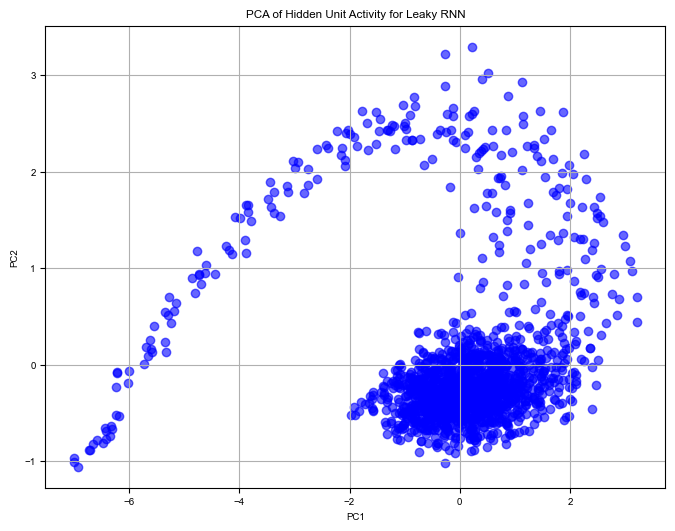

Varianza explicada por cada componente principal: [0.6266528  0.18930542]


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generar una entrada aleatoria para simular datos
seq_len = 100  # Longitud de la secuencia
batch_size = 16  # Procesar múltiples secuencias
input_size = net.rnn.input_size

input_rnn = torch.rand(seq_len, batch_size, input_size)

# Pasar los datos a través de la red para obtener activaciones ocultas
_, rnn_output = net(input_rnn)

# `rnn_output` tiene la forma (SeqLen, Batch, HiddenSize)
# Convertir a numpy y a una matriz 2D (combinar tiempo y lotes)
hidden_activity = rnn_output.detach().numpy()
hidden_activity_reshaped = hidden_activity.reshape(-1, hidden_activity.shape[2])  # (SeqLen * Batch, HiddenSize)

# Aplicar PCA
n_components = 2  # Número de componentes principales a analizar
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(hidden_activity_reshaped)

# Graficar los dos primeros componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.6, c='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Hidden Unit Activity for Leaky RNN')
plt.grid(True)
plt.show()

# Explicar la varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente principal: {explained_variance}')


Now we will do the same, but with a variation of the Leaky RNN that modifies the architecture to implement Dale's law, that 'a neuron releases the same neurotransmitters at all its outgoing synapses'.

In [13]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\Agustin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


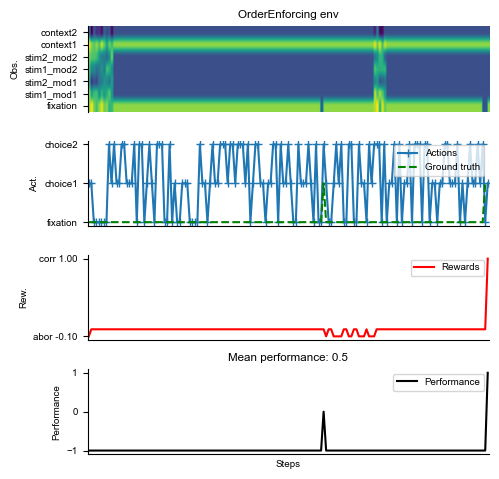

In [14]:
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task_name = 'ContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Now training the network.

In [15]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=7, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 200, Loss 0.3658
Step 400, Loss 0.2084
Step 600, Loss 0.1581
Step 800, Loss 0.1287
Step 1000, Loss 0.1079
Step 1200, Loss 0.0938
Step 1400, Loss 0.0830
Step 1600, Loss 0.0755
Step 1800, Loss 0.0690
Step 2000, Loss 0.0646


And now testing it.

In [16]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info
    if trial_info['ground_truth'] == 0:
        print(f'Hay un rojo en el número {i}')

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    #rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    #stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.502


Está listo lo de las excitadoras e inhibidoras, lo de la función de pérdida no todavía. Ahora para visualizar lo producido.

Text(0, 0.5, 'Activity')

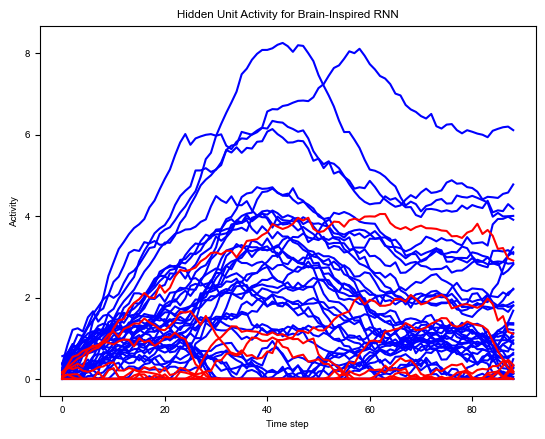

In [17]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.title('Hidden Unit Activity for Brain-Inspired RNN')
plt.xlabel('Time step')
plt.ylabel('Activity')

Text(0.5, 1.0, 'Network connectivity')

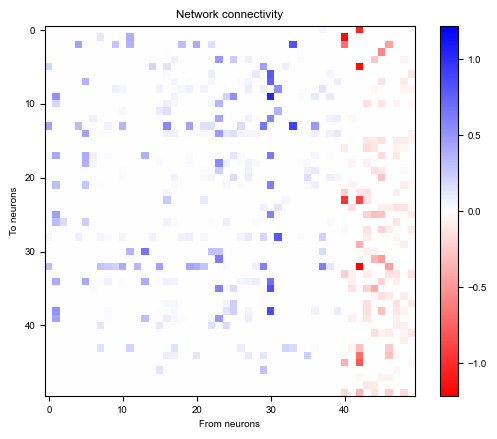

In [18]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

#mean_activity = []
#std_activity = []
#for ground_truth in [0, 1]:
#    activity = np.concatenate(stim_activity[ground_truth], axis=0)
#    mean_activity.append(np.mean(activity, axis=0))
#    std_activity.append(np.std(activity, axis=0))
#
## Compute d'
#selectivity = (mean_activity[0] - mean_activity[1])
#selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)
#
## Sort index for selectivity, separately for E and I
##ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
#                           np.argsort(selectivity[e_size:])+e_size))#

## @title Plot network connectivity sorted by stimulus selectivity#

## import warnings
## warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")#

## Plot distribution of stimulus selectivity
#plt.figure()
#plt.hist(selectivity)
#plt.xlabel('Selectivity')
#plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, :][:, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

Shape of the neural activity (Time points, Neurons): (48132, 50)
Shape of the projected activity (Time points, PCs): (48132, 2)


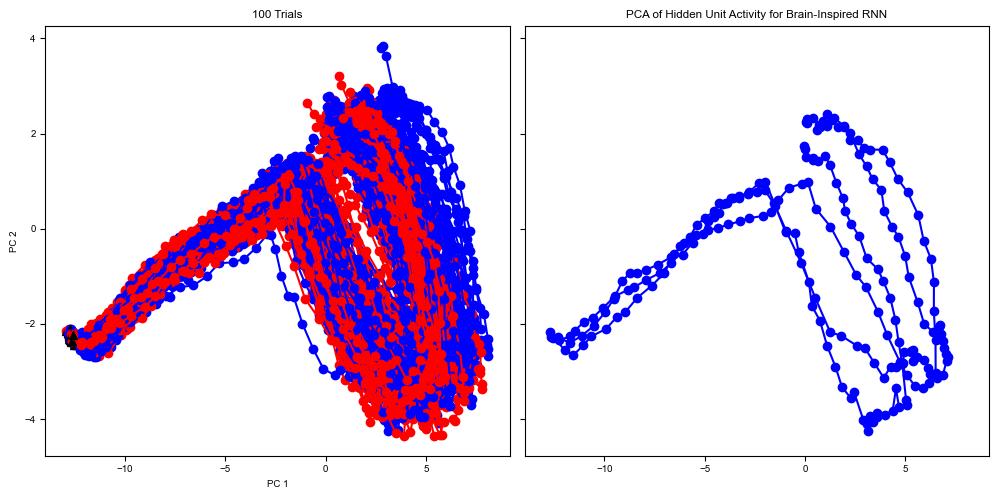

In [22]:
# PCA Analysis
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.title('PCA of Hidden Unit Activity for Brain-Inspired RNN')

plt.tight_layout()
plt.show()


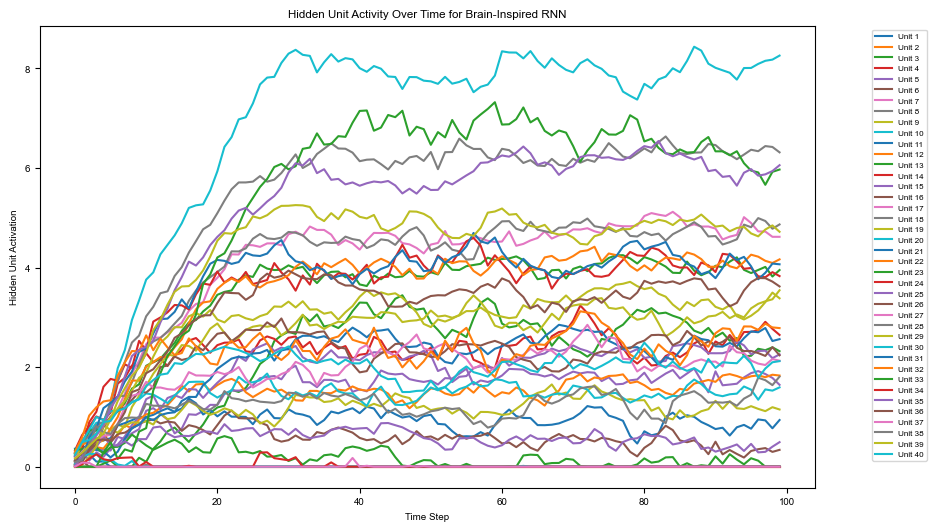

In [23]:
# Ejecutar un forward pass en la red para generar actividad oculta
seq_len = 100  # Longitud de la secuencia
batch_size = 1  # Procesar un lote a la vez para análisis individual
input_size = net.rnn.input_size

# Crear una entrada aleatoria para simular datos
input_rnn = torch.rand(seq_len, batch_size, input_size)

# Pasar los datos a través de la red
_, rnn_output = net(input_rnn)

# `rnn_output` tiene la forma (SeqLen, Batch, HiddenSize)
# Seleccionar el primer lote
hidden_activity = rnn_output[:, 0, :].detach().numpy()

# Graficar la actividad de las unidades ocultas
plt.figure(figsize=(10, 6))
for i in range(hidden_activity.shape[1]//5*4):
    plt.plot(hidden_activity[:, i], label=f'Unit {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit Activation')
plt.title('Hidden Unit Activity Over Time for Brain-Inspired RNN')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, fontsize='small')
plt.show()

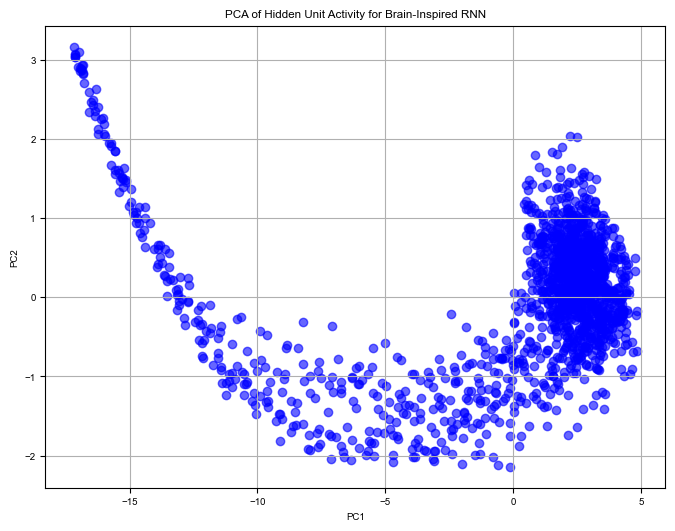

Varianza explicada por cada componente principal: [0.93051016 0.02677535]


In [24]:
# Generar una entrada aleatoria para simular datos
seq_len = 100  # Longitud de la secuencia
batch_size = 16  # Procesar múltiples secuencias
input_size = net.rnn.input_size

input_rnn = torch.rand(seq_len, batch_size, input_size)

# Pasar los datos a través de la red para obtener activaciones ocultas
_, rnn_output = net(input_rnn)

# `rnn_output` tiene la forma (SeqLen, Batch, HiddenSize)
# Convertir a numpy y a una matriz 2D (combinar tiempo y lotes)
hidden_activity = rnn_output.detach().numpy()
hidden_activity_reshaped = hidden_activity.reshape(-1, hidden_activity.shape[2])  # (SeqLen * Batch, HiddenSize)

# Aplicar PCA
n_components = 2  # Número de componentes principales a analizar
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(hidden_activity_reshaped)

# Graficar los dos primeros componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.6, c='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Hidden Unit Activity for Brain-Inspired RNN')
plt.grid(True)
plt.show()

# Explicar la varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente principal: {explained_variance}')